In [60]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport grouping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import numpy as np
from tqdm.auto import tqdm
from joblib import delayed, Parallel
from os import remove, mkdir
from qiskit.test.mock import FakeMontreal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from grouping import Grouping

try:
    mkdir('data')
except FileExistsError:
    pass

# TODO: Use modified tqdm when available

In [62]:
#TODO: use molecule when available
def random_labels(n, N):
    labels = []
    for i in range(n):
        labels.append(np.random.randint(4, size=N))
    return np.array(labels)

In [70]:
def n_groups(file_name):
    groups = Grouping(load=file_name)
    
    groups._shuffle_labels()
    groups._shuffle_qubits()
    
    groups.group()
    
    return groups.n_groups, groups.grouping_time

def parallel_shuffling(labels, file_name, transpiled_order, connected_graph, name_algoritm, n_reps=100):
    file_name_temp = 'tmp_grouping'
    grouping = Grouping(labels, WC_device, print_progress=False, transpiled_order=transpiled_order,
                                connected_graph=connected_graph, tests=None)
    grouping.save_data(file_name_temp)

    pbar = tqdm(range(n_reps), desc='Shuffling Pauli and qubits order ({})'.format(name_algoritm))
    results = Parallel(n_jobs=-1)(delayed(n_groups)(file_name_temp) for _ in pbar)
    
    remove(file_name_temp + '.pickle')
    
    n_groups_list = [result[0] for result in results]
    time = [result[1] for result in results]
    
    data = {'n_groups': n_groups_list, 'time': time}
    np.save('data/' + file_name + '_' + name_algoritm, data)
    
    return data

In [78]:
backend = FakeMontreal()
WC_device = backend.configuration().coupling_map
WC_device = [tuple(x) for x in WC_device]

n = 500
N = 10

labels = random_labels(n, N)

In [79]:
def compare_algorithms(labels, name_data, n_reps=100):
    data = {}
    
    # Naive
    data['naive'] = parallel_shuffling(labels, name_data, transpiled_order=False, connected_graph=None, name_algoritm='naive', n_reps=n_reps)
    
    # Disconnected
    data['disconnected'] = parallel_shuffling(labels, name_data, transpiled_order=True, connected_graph=False, name_algoritm='disconnected', n_reps=n_reps)
    
    # Connected
    data['connected'] = parallel_shuffling(labels, name_data, transpiled_order=True, connected_graph=True, name_algoritm='connected', n_reps=n_reps)
    
    return data

In [80]:
data = compare_algorithms(labels, 'test', n_reps=100)

Shuffling Pauli and qubits order (naive):   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling Pauli and qubits order (disconnected):   0%|          | 0/100 [00:00<?, ?it/s]

Shuffling Pauli and qubits order (connected):   0%|          | 0/100 [00:00<?, ?it/s]

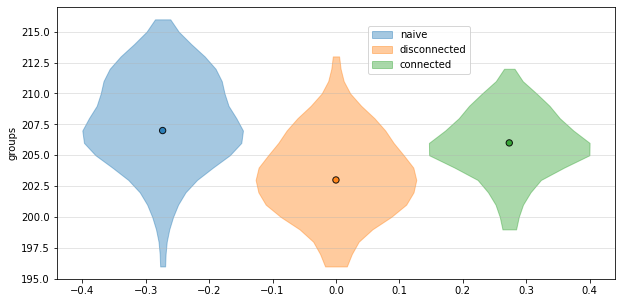

In [81]:
labels = ['naive', 'disconnected', 'connected']
colors = ['C0', 'C1', 'C2']

fig, ax = plt.subplots(figsize=(10, 5))

w_spacing = 0.02  # Spacing between bar of equal n_qubits
w_spacing_big = 0.1  # Spacing between bars of different n_qubits
w_bar = (1 - 2 * w_spacing_big - 2 * w_spacing) / 3
delta = 1 / 2 - w_spacing_big - w_bar / 2

x_pos_mean = []
y_pos_mean = []
color_mean = []
labels_legend = []

j = 0
for (i, label) in enumerate(labels):
    data_plot = data[label]['n_groups']
    violin_parts = ax.violinplot(data_plot, showextrema=False, positions=[j + delta * (i - 1)], widths=w_bar,
                                 points=min(1e6, int(np.max(data_plot) - np.min(data_plot)) + 1))

    for pc in violin_parts['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_edgecolor(colors[i])
        pc.set_alpha(0.4)

    x_pos_mean.append(j + delta * (i - 1))
    y_pos_mean.append(np.median(data_plot))
    color_mean.append(colors[i])

    color = violin_parts["bodies"][0].get_facecolor().flatten()
    labels_legend.append((mpatches.Patch(color=color), label.replace('_', ' ')))


ax.scatter(x_pos_mean, y_pos_mean, marker='o', c=color_mean, s=40, zorder=3, alpha=0.9, edgecolors='k')

# ax.set_xticks(range(0, len(n_qubits.keys())))
# ax.set_xticklabels(ticks_labels)
# ax.set_xlabel('molecule')
ax.set_ylabel('groups')
# ax.set_ylim(0, None)

ax.yaxis.grid(zorder=0, alpha=0.4)
ax.legend(*zip(*labels_legend), bbox_to_anchor=(0.75, 0.95))

# axins = inset_axes(ax, width="100%", height="100%",
#                    bbox_to_anchor=(0.07, .45, .5, .5),
#                    bbox_transform=ax.transAxes)


# for (i, label) in enumerate(labels):
#     data_plot_x = []
#     data_plot_y = []

#     data_plot_y.append(np.average(data[label]['time']))
#     data_plot_x.append(0)

#     axins.plot(data_plot_x, data_plot_y, c=colors[i], marker='.')
        
# axins.set_ylabel('average time (s)')

# axins.set_xticks(list(n_qubits.values()))
# axins.set_xticklabels(ticks_labels);